## Time Series Forecasting: XGBOOST

### Prepare Data

<strong>Refresh Data Preparation Notebook & Variables</strong>

In [1]:
# Run Data Preperation Notebook
%run -i 0_Data_Preparation.py

# Import Stored Variables
%store -r cpi_df gdp_df fedrev_df pce_df fedfunds_df feddebt_df psave_df revolcredit_df unemploy_df infl_df cc_outstanding_df merged_df dataset_dict

print('\nEconomic datasets:')
[print(v) for k, v in dataset_dict.items()]

print('\nmerged_df:')
merged_df.tail()


Economic datasets:
cpi_df
gdp_df
fedrev_df
pce_df
fedfunds_df
feddebt_df
psave_df
revolcredit_df
cc_outstanding_df
unemploy_df
sgdp_df
infl_df

merged_df:


,DATE,CPI,GDP,FEDREV_mm_nom,PCE,FEDFUNDS,GFDEBTN,PSAVERT,REVOLSL,TOTALSL,UNRATE,SGDP,INFL
1033,2023-08-01,306.269,NaN,NaN,18689.9,5.33,NaN,4.2,1288.12390,4972.49265,3.8,NaN,3.707504
1034,2023-09-01,307.481,NaN,NaN,18823.4,5.33,NaN,3.7,1292.56745,4984.71756,3.8,NaN,3.689903
1035,2023-10-01,307.619,NaN,NaN,18864.7,5.33,NaN,3.8,1295.44619,4989.85178,3.9,NaN,3.232356
1036,2023-11-01,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,2024-01-01,NaN,NaN,5036380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<strong>Import Libraries</strong>

In [2]:
# Import Libraries
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn
import datetime
import dateutil.relativedelta
from dateutil import relativedelta
import math
import matplotlib.dates as mdates
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

### Create War Dataframe

In [3]:
def war_df(df, start_date, end_date, cutoff_date=None, lag_pre=0, lag_post=0):

    # Calculate War Period & Dates
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    war_period = relativedelta.relativedelta(end_date, start_date)

    lag_pre = start_date - dateutil.relativedelta.relativedelta(years=lag_pre)
    lag_post = end_date + dateutil.relativedelta.relativedelta(years=lag_post)

    # Create War Dataframe
    df_all = df.loc[(df.DATE >= lag_pre.strftime('%Y-%m-%d')) & (df.DATE <= lag_post.strftime('%Y-%m-%d'))]

    # War Status
    df_all.loc[df.DATE < start_date.strftime('%Y-%m-%d'),'Status'] = 'pre'
    df_all.loc[df.DATE > end_date.strftime('%Y-%m-%d'),'Status'] = 'post'
    df_all.loc[(df.DATE >= start_date.strftime('%Y-%m-%d')) & (df.DATE <= end_date.strftime('%Y-%m-%d')),'Status'] = 'during'

    # War Train Test
    train_test_split = 0.25

    if cutoff_date is not None:
        cutoff_date = datetime.datetime.strptime(cutoff_date, '%Y-%m-%d')
        df_all.loc[df.DATE < cutoff_date.strftime('%Y-%m-%d'),'Train_Test'] = 'train'
        df_test_count = math.ceil(len(df_all[df_all.Train_Test=='train'])*train_test_split)
        df_all = df_all.reset_index(drop=True)
        df_all.loc[df_test_count*3:(df_test_count*4)-1,'Train_Test'] = 'test'
    else:
        df_all.loc[df.DATE < start_date.strftime('%Y-%m-%d'),'Train_Test'] = 'train'
        df_test_count = math.ceil(len(df_all[df_all.Train_Test=='train'])*train_test_split)
        df_all = df_all.reset_index(drop=True)
        df_all.loc[df_test_count*3:(df_test_count*4)-1,'Train_Test'] = 'test'

    return df_all

In [4]:
# Separate DataFrame for Model Training
def war_cutoff_df(df):

    cutoff_index = np.where(df.Train_Test=='cutoff')[0][0]
    df_cutoff = df.iloc[:cutoff_index]

    return df_cutoff

## Vietnam War

In [5]:
# Create War Dataframe
vietnam_war_df = war_df(gdp_df, '1955-11-01', '1975-04-30', lag_pre=10, lag_post=10)
vietnam_war_df.head()

,DATE,GDP,Status,Train_Test
0,1947-01-01,243.164,pre,train
1,1947-04-01,245.968,pre,train
2,1947-07-01,249.585,pre,train
3,1947-10-01,259.745,pre,train
4,1948-01-01,265.742,pre,train


In [6]:
# Set Vietnam War dataframe index to the 'DATE' column
# Use 'Train_Test' column to create separate dataframes for train data and test data

vietnam_war_df = vietnam_war_df.set_index('DATE')
vietnam_war_df.index = pd.to_datetime(vietnam_war_df.index)
train = vietnam_war_df[vietnam_war_df['Train_Test'] == 'train']
test = vietnam_war_df[vietnam_war_df['Train_Test'] == 'test']

### Train & Test Split Visualization

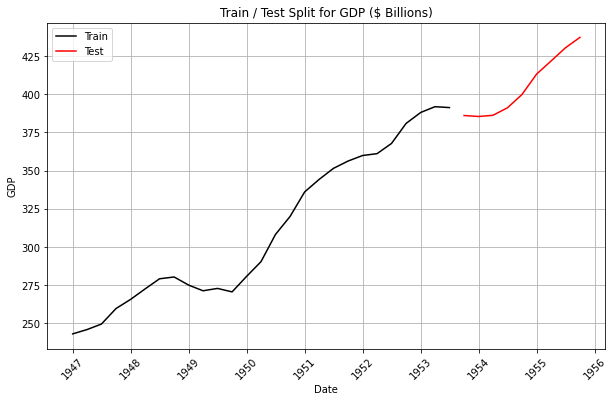

In [7]:
# Plot Train, Test
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(train.index, train.GDP, color='black', label='Train')
plt.plot(test.index, test.GDP, color='red', label='Test')
plt.xticks(rotation=45)
plt.title('Train / Test Split for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### Create Features for XGBoost Model, Pre-War (Train / Test)

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'year']
TARGET = 'GDP'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Hyperparameter Tuning with GridSearchCV

In [10]:
# This process can take a long time to run. To speed up the GridSearchCV, you can change the number of values
# that each parameter is testing.

parameters = {
    'n_estimators': [400, 600,800,1000],
    'learning_rate': [ 0.01, 0.05, 0.1, 0.5, 1.0],
    'max_depth': [2, 3, 4],
    'gamma': [0, 0.01, 0.02],
    'reg_lambda': [0,.001],
    'random_state': [42]
}


model = xgb.XGBRegressor(default = 'gbtree',objective='reg:linear')
reg = GridSearchCV(model, parameters, scoring = 'neg_root_mean_squared_error')

reg.fit(X_train, y_train)

print(f'Best params: {reg.best_params_}')
print(f'Best validation score = {reg.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 800, 'random_state': 42, 'reg_lambda': 0.001}
Best validation score = -17.24880584471257


In [11]:
model = xgb.XGBRegressor(**reg.best_params_, objective='reg:linear')
model.fit(X_train, y_train,verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.02, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### XGBoost Model Scoring

In [12]:
test['prediction'] = model.predict(X_test)
score = np.sqrt(mean_squared_error(test['GDP'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 22.64


### *Optional* Micro Adjusting Hyperparameters

In [13]:
# Below can be used to further refine your hyperparameters in a faster method using the output from your
# GridSearchCV as a baseline.

model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.05,
                       gamma=.03,
                       reg_lambda = .001,
                       reg_alpha = 0,
                       min_child_weight = 3)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:299.25169	validation_1-rmse:386.06094
[100]	validation_0-rmse:4.31837	validation_1-rmse:24.73965
[200]	validation_0-rmse:3.22502	validation_1-rmse:22.55899
[300]	validation_0-rmse:2.99402	validation_1-rmse:22.42727
[400]	validation_0-rmse:2.63553	validation_1-rmse:22.34442
[500]	validation_0-rmse:2.33803	validation_1-rmse:22.32952
[534]	validation_0-rmse:2.31586	validation_1-rmse:22.34942


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.03, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### XGBoost Feature Importance

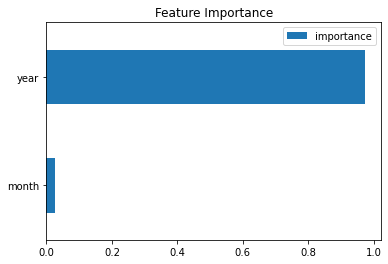

In [14]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Train, Test, & Predictions based on XGBoost Output

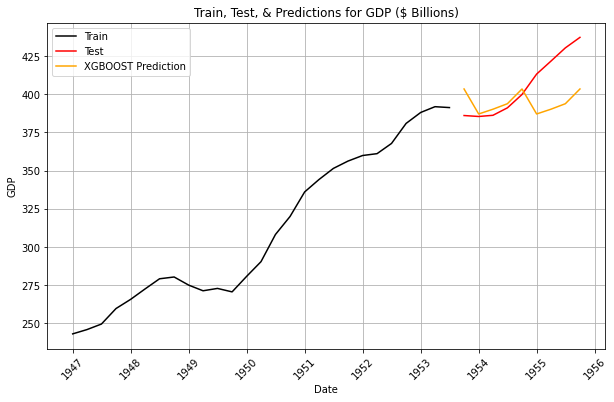

                GDP Status Train_Test  month  year  prediction
DATE                                                          
1953-10-01  385.970    pre       test     10  1953  401.075928
1954-01-01  385.345    pre       test      1  1954  388.034882
1954-04-01  386.121    pre       test      4  1954  391.316803
1954-07-01  390.996    pre       test      7  1954  391.362000
1954-10-01  399.734    pre       test     10  1954  401.075928
1955-01-01  413.073    pre       test      1  1955  388.034882
1955-04-01  421.532    pre       test      4  1955  391.316803
1955-07-01  430.221    pre       test      7  1955  391.362000
1955-10-01  437.092    pre       test     10  1955  401.075928 

[403.33878 386.98834 390.09256 393.69687 403.33878 386.98834 390.09256
 393.69687 403.33878]


In [15]:
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(train.index, train.GDP, color='black', label='Train')
plt.plot(test.index, test.GDP, color='red', label='Test')
plt.plot(test.index, model.predict(X_test), color='orange', label = 'XGBOOST Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.title('Train, Test, & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

print(test,'\n')
print(model.predict(X_test))

### Visualizing GDP during Vietnam War + Post War

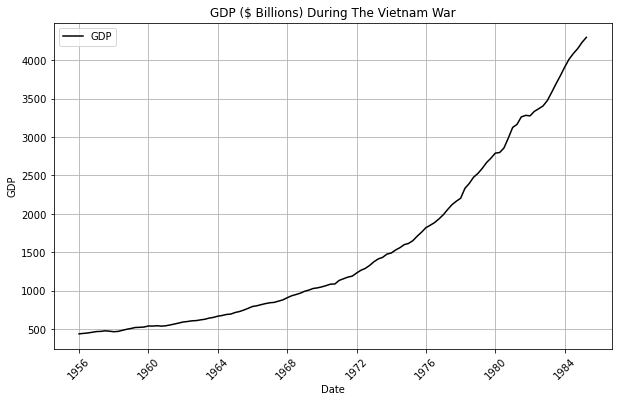

In [16]:
# Plot Vietnam War
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(vietnam_war_df[vietnam_war_df['Status'] != 'pre'].index,
vietnam_war_df[vietnam_war_df['Status'] != 'pre'].GDP, color='black', label='GDP')
plt.xticks(rotation=45)
plt.title('GDP ($ Billions) During The Vietnam War')
plt.legend()
plt.grid(True)
plt.show()

### Getting Features for Vietnam War + Post War

In [17]:
vw_df = create_features(vietnam_war_df[vietnam_war_df['Status'] != 'pre'])
X = vw_df[FEATURES]
y= vw_df[TARGET]
vw_df['prediction'] = model.predict(X)

### Visualizing GDP Actuals & Predictions for Vietnam War + Post War

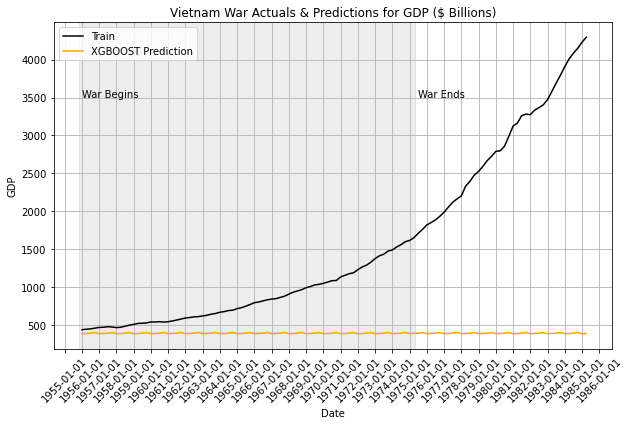

                 GDP  Status Train_Test  month  year  prediction
DATE                                                            
1956-01-01   439.746  during        NaN      1  1956  386.988342
1956-04-01   446.010  during        NaN      4  1956  390.092560
1956-07-01   451.191  during        NaN      7  1956  393.696869
1956-10-01   460.463  during        NaN     10  1956  403.338776
1957-01-01   469.779  during        NaN      1  1957  386.988342
...              ...     ...        ...    ...   ...         ...
1984-04-01  4009.601    post        NaN      4  1984  390.092560
1984-07-01  4084.250    post        NaN      7  1984  393.696869
1984-10-01  4148.551    post        NaN     10  1984  403.338776
1985-01-01  4230.168    post        NaN      1  1985  386.988342
1985-04-01  4294.887    post        NaN      4  1985  390.092560

[118 rows x 6 columns] 

[403.33878 386.98834 390.09256 393.69687 403.33878 386.98834 390.09256
 393.69687 403.33878]


In [18]:
#xdates = [dt.strptime(dstr,'%Y-%m-%d') for dstr in vietnam_war_predictions_df.DATE]

plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(vw_df.index, vw_df.GDP, color='black', label='Train')
plt.plot(vw_df.index, model.predict(X), color='orange', label = 'XGBOOST Prediction')
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.axvspan('1955-11-01', '1975-04-30', color='k', alpha=0.07)
plt.text(vw_df.index[0],3500,'War Begins')
plt.text(vw_df.index[78],3500,'War Ends')
plt.legend()
plt.xticks(rotation=45)
plt.title('Vietnam War Actuals & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

print(vw_df,'\n')
print(model.predict(X_test))

### XGBoost Model Score on Vietnam War + Post War

In [19]:
score = np.sqrt(mean_squared_error(vw_df['GDP'], vw_df['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1597.37


## Afghanistan War

In [20]:
afghanistan_war_df = war_df(gdp_df, '2001-09-18', '2021-08-30', lag_pre=10, lag_post=10)
afghanistan_war_df

,DATE,GDP,Status,Train_Test
0,1991-10-01,6264.540,pre,train
1,1992-01-01,6363.102,pre,train
2,1992-04-01,6470.763,pre,train
3,1992-07-01,6566.641,pre,train
4,1992-10-01,6680.803,pre,train
...,...,...,...,...
123,2022-07-01,25994.639,post,NaN
124,2022-10-01,26408.405,post,NaN
125,2023-01-01,26813.601,post,NaN
126,2023-04-01,27063.012,post,NaN


In [21]:
# Set Afghanistan War dataframe index to the 'DATE' column
# Use 'Train_Test' column to create separate dataframes for train data and test data

afghanistan_war_df = afghanistan_war_df.set_index('DATE')
afghanistan_war_df.index = pd.to_datetime(afghanistan_war_df.index)
train = afghanistan_war_df[afghanistan_war_df['Train_Test'] == 'train']
test = afghanistan_war_df[afghanistan_war_df['Train_Test'] == 'test']

### Train & Test Split Visualization

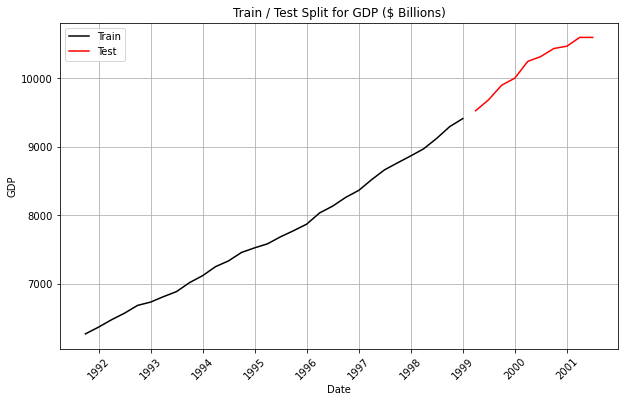

In [22]:
# Plot Train, Test
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(train.index, train.GDP, color='black', label='Train')
plt.plot(test.index, test.GDP, color='red', label='Test')
plt.xticks(rotation=45)
plt.title('Train / Test Split for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

### Create Features for XGBoost Model, Pre-War (Train / Test)

In [23]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'year']
TARGET = 'GDP'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Hyperparameter Tuning with GridSearchCV

In [24]:
# This process can take a long time to run. To speed up the GridSearchCV, you can change the number of values
# that each parameter is testing.

parameters = {
    'n_estimators': [400, 600,800,1000],
    'learning_rate': [ 0.01, 0.05, 0.1, 0.5, 1.0],
    'max_depth': [2, 3, 4],
    'gamma': [0, 0.01, 0.02],
    'reg_lambda': [0,.001],
    'random_state': [42]
}


model = xgb.XGBRegressor(default = 'gbtree',objective='reg:linear')
reg = GridSearchCV(model, parameters, scoring = 'neg_root_mean_squared_error')

reg.fit(X_train, y_train)

print(f'Best params: {reg.best_params_}')
print(f'Best validation score = {reg.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'random_state': 42, 'reg_lambda': 0.001}
Best validation score = -294.78690994642795


In [25]:
model = xgb.XGBRegressor(**reg.best_params_, objective='reg:linear')
model.fit(X_train, y_train,verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### XGBoost Model Scoring

In [26]:
test['prediction'] = model.predict(X_test)
score = np.sqrt(mean_squared_error(test['GDP'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 747.74


### *Optional* Micro Adjusting Hyperparameters

In [27]:
# Below can be used to further refine your hyperparameters in a faster method using the output from your
# GridSearchCV as a baseline.

model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=.5,
                       gamma= 0.001,
                       reg_lambda = 0.001,
                       reg_alpha = 0.001)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3895.89904	validation_1-rmse:5624.38221
[100]	validation_0-rmse:10.05481	validation_1-rmse:723.97614
[200]	validation_0-rmse:7.30101	validation_1-rmse:721.00370
[282]	validation_0-rmse:4.98515	validation_1-rmse:719.56680


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### XGBoost Feature Importance

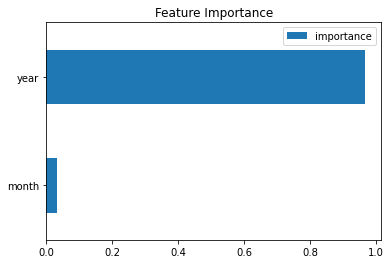

In [28]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Train, Test, & Predictions based on XGBoost Output

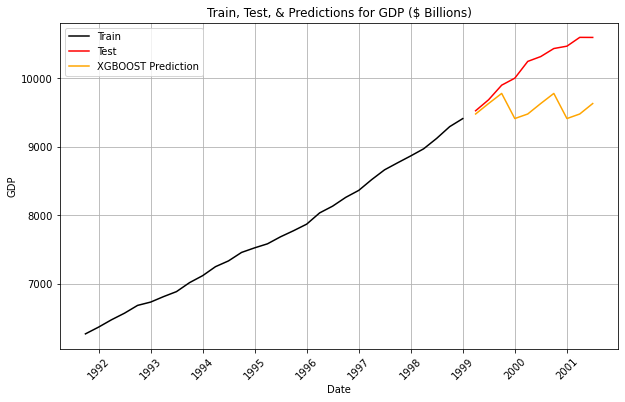

                  GDP Status Train_Test  month  year   prediction
DATE                                                             
1999-04-01   9526.210    pre       test      4  1999  9457.962891
1999-07-01   9686.626    pre       test      7  1999  9563.212891
1999-10-01   9900.169    pre       test     10  1999  9725.116211
2000-01-01  10002.179    pre       test      1  2000  9411.676758
2000-04-01  10247.720    pre       test      4  2000  9457.962891
2000-07-01  10318.165    pre       test      7  2000  9563.212891
2000-10-01  10435.744    pre       test     10  2000  9725.116211
2001-01-01  10470.231    pre       test      1  2001  9411.676758
2001-04-01  10599.000    pre       test      4  2001  9457.962891
2001-07-01  10598.020    pre       test      7  2001  9563.212891 

[9478.833 9631.607 9779.323 9412.149 9478.833 9631.607 9779.323 9412.149
 9478.833 9631.607]


In [29]:
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(train.index, train.GDP, color='black', label='Train')
plt.plot(test.index, test.GDP, color='red', label='Test')
plt.plot(test.index, model.predict(X_test), color='orange', label = 'XGBOOST Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.title('Train, Test, & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

print(test,'\n')
print(model.predict(X_test))

### Visualizing GDP during Afghanistan War + Post War

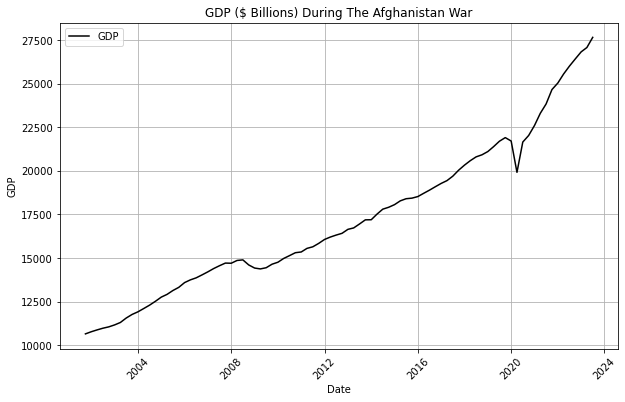

In [30]:
# Plot Afghanistan War
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(afghanistan_war_df[afghanistan_war_df['Status'] != 'pre'].index,
afghanistan_war_df[afghanistan_war_df['Status'] != 'pre'].GDP, color='black', label='GDP')
plt.xticks(rotation=45)
plt.title('GDP ($ Billions) During The Afghanistan War')
plt.legend()
plt.grid(True)
plt.show()

### Getting Features for Afghanistan War + Post War

In [31]:
aw_df = create_features(afghanistan_war_df[afghanistan_war_df['Status'] != 'pre'])
X = aw_df[FEATURES]
y= aw_df[TARGET]
aw_df['prediction'] = model.predict(X)

### Visualizing GDP Actuals & Predictions for Afghanistan War + Post War

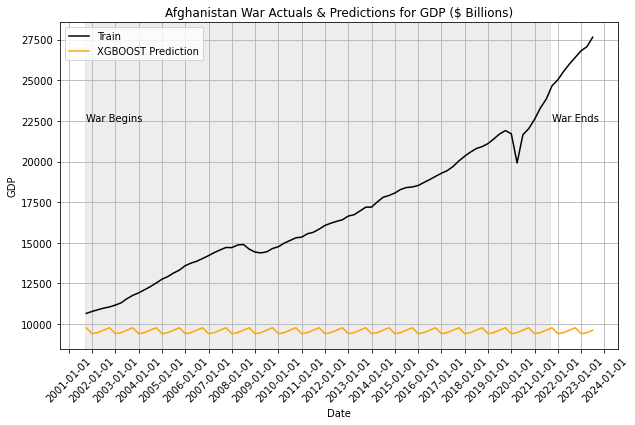

                  GDP  Status Train_Test  month  year   prediction
DATE                                                              
2001-10-01  10660.465  during        NaN     10  2001  9779.323242
2002-01-01  10783.500  during        NaN      1  2002  9412.149414
2002-04-01  10887.460  during        NaN      4  2002  9478.833008
2002-07-01  10984.040  during        NaN      7  2002  9631.607422
2002-10-01  11061.433  during        NaN     10  2002  9779.323242
...               ...     ...        ...    ...   ...          ...
2022-07-01  25994.639    post        NaN      7  2022  9631.607422
2022-10-01  26408.405    post        NaN     10  2022  9779.323242
2023-01-01  26813.601    post        NaN      1  2023  9412.149414
2023-04-01  27063.012    post        NaN      4  2023  9478.833008
2023-07-01  27644.463    post        NaN      7  2023  9631.607422

[88 rows x 6 columns] 

[9478.833 9631.607 9779.323 9412.149 9478.833 9631.607 9779.323 9412.149
 9478.833 9631.607]


In [32]:
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(aw_df.index, aw_df.GDP, color='black', label='Train')
plt.plot(aw_df.index, model.predict(X), color='orange', label = 'XGBOOST Prediction')
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.axvspan('2001-09-18', '2021-08-30', color='k', alpha=0.07)
plt.text(aw_df.index[0],22500,'War Begins')
plt.text(aw_df.index[80],22500,'War Ends')
plt.legend()
plt.xticks(rotation=45)
plt.title('Afghanistan War Actuals & Predictions for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

print(aw_df,'\n')
print(model.predict(X_test))

### XGBoost Model Score on Afghanistan War + Post War

In [33]:
score = np.sqrt(mean_squared_error(aw_df['GDP'], aw_df['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 8803.59


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba1e4b21-f3e5-4d67-887d-75e6f1b74e8f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>